# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DATA_FOLDER = './data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:80: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykerne

         Liberia new cases  Liberia death  Guinea new cases  Guinea death  Sierra new cases  Sierra death
Date                                                                                                     
06/2014           2.142857       1.285714               NaN           NaN               NaN           NaN
07/2014           1.818182       1.538462               NaN           NaN               NaN           NaN
08/2014           5.444444       9.444444           12.4000      3.892857         19.600000      6.150000
09/2014           6.166667      30.933333           12.5625      6.965517         36.275862     17.566667
10/2014           1.400000      37.064516            6.0000     23.000000         57.535714     46.000000
11/2014           2.600000       0.000000               NaN           NaN         63.238095    102.137931
12/2014           3.333333       0.000000               NaN           NaN         32.600000    131.384615


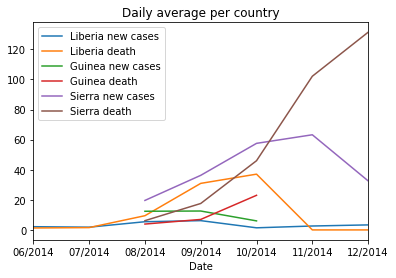

In [5]:
import glob

import matplotlib.pyplot as plt
import pandas as pd

THRESHOLD = 1000

def readCSVbyCountry(path):
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    df = pd.concat(list_)
    df = pd.DataFrame(df)
    df.dropna(axis=0, how='all')
    df = df.fillna(0)
    return df

def getResult(df_confirmed, df_newcases, label):
    # For each country I store: 
    # - the max value of deaths per month
    # - the min value of deaths per month
    # - the last day of the month in which I registered data
    # - the first day of the month in which I registered data
    df_confirmed['max_deaths'] = df_confirmed.Date.map(lambda x: df_confirmed.groupby('Date')['MAX'].max()[x])
    df_confirmed['max_day'] = df_confirmed.Date.map(lambda x: df_confirmed.groupby('Date')['day'].max()[x])
    df_confirmed['min_deaths'] = df_confirmed.Date.map(lambda x: df_confirmed.groupby('Date')['MAX'].min()[x])
    df_confirmed['min_day'] = df_confirmed.Date.map(lambda x: df_confirmed.groupby('Date')['day'].min()[x])
    
    # I compute the number of days from FIRST and LAST day stored before
    df_confirmed['days'] = df_confirmed['max_day'] - df_confirmed['min_day'] + 1
    df_confirmed = df_confirmed.groupby(['Date']).first()
    del df_confirmed['MAX']
    del df_confirmed['day']
    del df_confirmed['min_day']
    del df_confirmed['max_day']
    
    # To prevent some typo errors in sierra leone dataset
    df_newcases = df_newcases[df_newcases['MAX'] < THRESHOLD]
    
    # Get the daily average new cases confirmed per month
    df_newcases[label+' new cases'] = df_newcases.Date.map(lambda x: df_newcases.groupby('Date')['MAX'].mean()[x])
    df_newcases = df_newcases.groupby(['Date']).first()
    del df_newcases['MAX']
    result = pd.merge(df_newcases.reset_index(), df_confirmed.reset_index(), on=['Date'], how='inner').set_index(
        ['Date'])
    
    # I get the montly deaths:
    # - by subtracting MAX-DEATHS and MIN-DEATHS
    # - by subtracting MAX-DEATHS and MAX-DEATHS of the previous month if MIN-DEATHS is the same for the month. 
    result['deaths_x'] = result['max_deaths'] - result['max_deaths'].shift(+1)
    result['deaths_y'] = result['max_deaths'].sub(result['min_deaths'], axis=0)
    result['deaths'] = result[['deaths_x', 'deaths_y']].max(axis=1)
    
    # Get the daily average deaths confirmed per month
    result[label+' death'] = result['deaths'] / result['days']
    del result['max_deaths']
    del result['min_deaths']
    del result['deaths']
    del result['deaths_x']
    del result['deaths_y']
    del result['days']
    del result['day']
    # Return the result dataframe
    return result

# PATHS of the datasets
path_guinea = r'./data/ebola/guinea_data'
path_liberia = r'./data/ebola/liberia_data'
path_sierraleone = r'./data/ebola/sl_data'

# Reading all datasets for COUNTRY
df = readCSVbyCountry(path_guinea)
df = df.set_index('Description')
col_list= list(df)
col_list.remove('Date')
col_list.remove('Totals')
df = df.convert_objects(convert_numeric=True)
df['TotalsByCity'] = df[col_list].sum(axis=1, numeric_only=True)
df = df.fillna(0)
df["MAX"] = df['TotalsByCity']
df = df[['MAX','Date']]
df['day'] = pd.DatetimeIndex(df['Date']).day
df.Date = pd.to_datetime(df.Date).dt.strftime('%m/%Y')
df_confirmed = df.loc['Total deaths of confirmed']
df_newcases = df.loc['New cases of confirmed']
result_guinea = getResult(df_confirmed, df_newcases, 'Guinea')

# Reading all datasets for COUNTRY
df = readCSVbyCountry(path_liberia)
df = df.set_index('Variable')
col_list= list(df)
col_list.remove('Date')
col_list.remove('National')
df = df.convert_objects(convert_numeric=True)
df['TotalsByCity'] = df[col_list].sum(axis=1, numeric_only=True)
df = df.fillna(0)
df["MAX"] = df[['TotalsByCity', 'National']].max(axis=1)
df = df[['MAX','Date']]
df['day'] = pd.DatetimeIndex(df['Date']).day
df.Date = pd.to_datetime(df.Date).dt.strftime('%m/%Y')
df_confirmed = df.loc['Total death/s in confirmed cases']
df_newcases = df.loc['New case/s (confirmed)']
result_liberia = getResult(df_confirmed, df_newcases, 'Liberia')

# Reading all datasets for COUNTRY
df = readCSVbyCountry(path_sierraleone)
df = df.set_index('variable')
col_list= list(df)
col_list.remove('date')
col_list.remove('National')
df = df.convert_objects(convert_numeric=True)
df['TotalsByCity'] = df[col_list].sum(axis=1, numeric_only=True)
df = df.fillna(0)
df["MAX"] = df['TotalsByCity']
df = df[['MAX','date']]
df.rename(columns={"date": "Date"}, inplace=True)
df['day'] = pd.DatetimeIndex(df['Date']).day
df.Date = pd.to_datetime(df.Date).dt.strftime('%m/%Y')
df_newcases = df.loc['new_confirmed']
df_confirmed = df.loc['death_confirmed']

result_sierra = getResult(df_confirmed, df_newcases, 'Sierra')

result = pd.merge(result_liberia.reset_index(), result_guinea.reset_index(), on=['Date'], how='outer').set_index(['Date'])
result = pd.merge(result.reset_index(), result_sierra.reset_index(), on=['Date'], how='outer').set_index(['Date'])
result.plot()
print(result.to_string())
plt.title('Daily average per country')
plt.show()


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [6]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [7]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

#### 1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

To begin with, the data is loaded from the excel sheet. In order to avoid problems with the '.' in the column name 'home.dest' we rename it to 'home_dest'. (In particular, accessing the column via a dot would yield an error otherwise.

In [8]:
titanic = pd.read_excel(DATA_FOLDER+'/titanic.xls', sheetname='titanic')
titanic.rename(columns={'home.dest': 'home_dest'}, inplace=True)
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Now let us take a closer look at the data types. Pandas detects the following types:

In [9]:
titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home_dest     object
dtype: object

Sometimes those types are more general than necessary, e.g. the name attribute could also be considered a String. However, our analysis worked well with the types as they are specified here and we therefore did not perform any casts.

For the numeric values, the value range can be seen in the overview statistics provided by the `describe` function (see the min and max values).

In [10]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


For the other attributes, one can not specify a range but it is possible to specify the set of possible values. For example, the name attribute consists of strings representing valid names. The ticket attribute, on the other hand, is essentially an integer value. The reason that it is still encoded as an object value is that some entries have the prefix 'PC' before the number, which results in a string value. If the attribute is needed in the further analysis it would make sense to delete this prefix. As the attribute is not used in our analysis we did not take further steps to clean the values of this attribute.

The other object typed attribute take a finite set of values which can be seen in the following analysis wich was performed in order to find out which values can be `Categorical`:

In [11]:
print(np.unique(titanic[['pclass']].values))
print(np.unique(titanic[['survived']].values))
print(np.unique(titanic[['sex']].values))
print(np.unique(titanic[['cabin']].dropna().values))
print(np.unique(titanic[['embarked']].dropna().values))
print(np.unique(titanic[['boat']].dropna().astype(str).values))
print(np.unique(titanic[['home_dest']].dropna().values))

[1 2 3]
[0 1]
['female' 'male']
['A10' 'A11' 'A14' 'A16' 'A18' 'A19' 'A20' 'A21' 'A23' 'A24' 'A26' 'A29'
 'A31' 'A32' 'A34' 'A36' 'A5' 'A6' 'A7' 'A9' 'B10' 'B101' 'B102' 'B11'
 'B18' 'B19' 'B20' 'B22' 'B24' 'B26' 'B28' 'B3' 'B30' 'B35' 'B36' 'B37'
 'B38' 'B39' 'B4' 'B41' 'B42' 'B45' 'B49' 'B5' 'B50' 'B51 B53 B55'
 'B52 B54 B56' 'B57 B59 B63 B66' 'B58 B60' 'B61' 'B69' 'B71' 'B73' 'B77'
 'B78' 'B79' 'B80' 'B82 B84' 'B86' 'B94' 'B96 B98' 'C101' 'C103' 'C104'
 'C105' 'C106' 'C110' 'C111' 'C116' 'C118' 'C123' 'C124' 'C125' 'C126'
 'C128' 'C130' 'C132' 'C148' 'C2' 'C22 C26' 'C23 C25 C27' 'C28' 'C30' 'C31'
 'C32' 'C39' 'C45' 'C46' 'C47' 'C49' 'C50' 'C51' 'C52' 'C53' 'C54'
 'C55 C57' 'C6' 'C62 C64' 'C65' 'C68' 'C7' 'C70' 'C78' 'C80' 'C82' 'C83'
 'C85' 'C86' 'C87' 'C89' 'C90' 'C91' 'C92' 'C93' 'C95' 'C97' 'C99' 'D'
 'D10 D12' 'D11' 'D15' 'D17' 'D19' 'D20' 'D21' 'D22' 'D26' 'D28' 'D30'
 'D33' 'D34' 'D35' 'D36' 'D37' 'D38' 'D40' 'D43' 'D45' 'D46' 'D47' 'D48'
 'D49' 'D50' 'D56' 'D6' 'D7' 'D9' 'E10

We decided to transform all those attributes but the home destination into Categoricals. We did not tranform the home destination attribute, because we considered the value range too big.

In [12]:
titanic['pclass'] = titanic.pclass.astype('category')
titanic['survived'] = titanic.survived.astype('category')
titanic['sex'] = titanic.sex.astype('category')
titanic['cabin'] = titanic.cabin.astype('category')
titanic['embarked'] = titanic.embarked.astype('category')
titanic['boat'] = titanic.boat.astype('category')

titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home_dest      object
dtype: object

#### 2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

The plots are created using the `plot` function. As we are not dealing with metric but with categoric variables for the travel class, embarkation port, and sex attributes we decided to do bar plots instead of histograms there. The data for the bar plots is prepared by calling the `value_counts` function which computes the counts of all unique values (excluing NaN). This is necessary because the plot consists of one bar per row. Furthermore, the data is sorted for the travel class such that the bars appear in the natural order. In all the plots the rotation of the bar captions is changed in order to make them more readable.

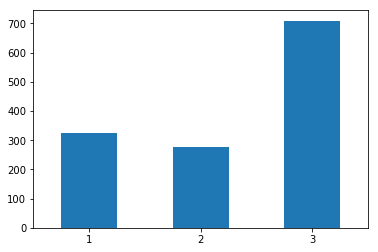

In [161]:
titanic['pclass'].value_counts().sort_index().plot(kind='bar', rot=0)

*Discussion:* More than half of the travellors where travelling in third class. The other travellors where fairly equally distributed between first and second class with a little more trabellors in the first class.

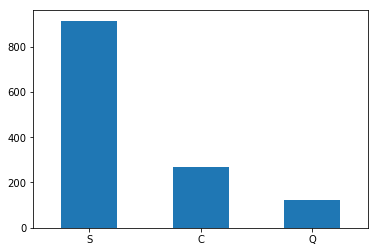

In [162]:
titanic['embarked'].value_counts().plot(kind='bar', rot=0)

*Discussion:* The big majority of travellors embarked in **S**outhampton, the next biggest groups are travellors who wmbarked in **C**herbourg, some also embarked in **Q**ueenstown.

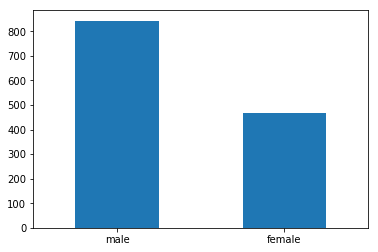

In [163]:
titanic['sex'].value_counts().plot(kind='bar', rot=0)

*Discussion*: Almost two thirds of the passengers where male.

As age is a metric variable, we used a histogram for this attribute. Discrete decade intervals can be enforced by manually specifying the bin boundaries, representing decades. Using values between 0 and 80 is reasonable with respect to the value range inspected in question 1.

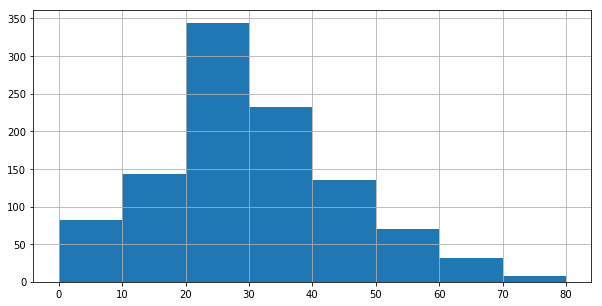

In [164]:
titanic.age.hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], figsize=[10, 5])

*Discussion:* The main passenger group where adults between 20 and 40. For older ages than that the number of passengers decreses with increasing age.

#### 3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
As can be seen in https://www.encyclopedia-titanica.org/titanic-deckplans/ the cabin floor is represented by a character in the beginning of the value of the cabin attribute.

In question 1, we found out that possible values are A, B, C, D, E, F, G and T. Although the value T might seem a little out of place, we assume that it might represent the Tank Top (https://www.encyclopedia-titanica.org/titanic-deckplans/tank-top.html) and therefore consider it a valid value.

In the first step we compute the number of missing values in the cabin column in order to be able to do a sanity check later. Then we drop the rows with missing cabin values and calculate for every possible floor character the number of entries starting with this character. Afterwards, we sum up the values in order to do a sanity check. Then the relative frequencies are computed and the information is stored in a dataframe in order to be able to create a pie chart.

1309
295
295
[ 0.07457627  0.22033898  0.31864407  0.1559322   0.13898305  0.07118644
  0.01694915  0.00338983]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa07f1e6240>], dtype=object)

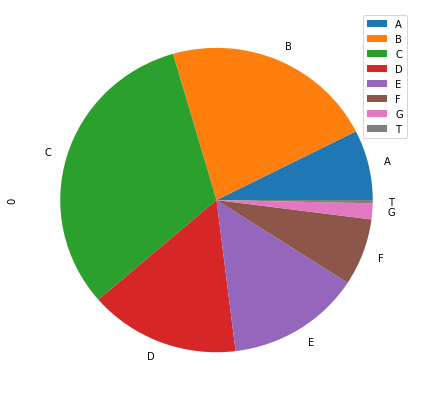

In [165]:
lenN = len(titanic[(titanic.cabin.isnull())])
cabins = titanic.cabin.dropna()
lenA = len(cabins[cabins.str.startswith('A')])
lenB = len(cabins[cabins.str.startswith('B')])
lenC = len(cabins[cabins.str.startswith('C')])
lenD = len(cabins[cabins.str.startswith('D')])
lenE = len(cabins[cabins.str.startswith('E')])
lenF = len(cabins[cabins.str.startswith('F')])
lenG = len(cabins[cabins.str.startswith('G')])
lenT = len(cabins[cabins.str.startswith('T')])

print(titanic.shape[0])
print(titanic.shape[0] - lenN)
freq=np.array([lenA, lenB, lenC, lenD, lenE, lenF, lenG, lenT])
print(freq.sum())
freq = freq/(titanic.shape[0] - lenN)
print(freq)
floors = pd.DataFrame(freq, index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

floors.plot(kind='pie', subplots=True, figsize=[7, 7])

*Discussion:* The pie chart shows the distribution of travellors over the different floors. Most of the passengers stayed on floor C. On the other extreme, only very little passengers stayed on the Tank Top 'T'.

#### 4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

For this question the dataframe is grouped by travel class. Then the proportion of survivors is computed using the `prop` function. It takes as input a dataframe, a column, and a value and computes the proportion of rows containing this value. In the same way the proportion of dead people is computed. Of course this proportion is just one minus the proportion of the survivors, but computing it like this gives an additional sanity check. Then the two dataframes are concatenated and the columns are assigned meaningful names. The resulting dataframe is represented by a set of pie charts. In order to get one pie chart per row, we take the transposed of the dataframe and set the `subplots` attribute to `True`.

pclass
1    0.619195
2    0.429603
3    0.255289
dtype: float64
pclass
1    0.380805
2    0.570397
3    0.744711
dtype: float64
        survived      dead
pclass                    
1       0.619195  0.380805
2       0.429603  0.570397
3       0.255289  0.744711


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa07f24f518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa07f4f4ef0>], dtype=object)

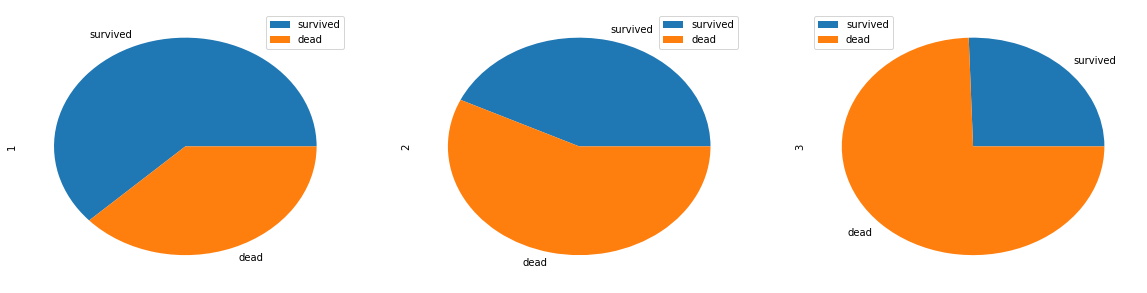

In [166]:
def prop(df, column, val):
    return len(df[df[column]==val])/len(df[column])

titanic_survived = titanic.groupby(titanic.pclass).apply(prop, 'survived', 1)
print(titanic_survived)
titanic_died = titanic.groupby(titanic.pclass).apply(prop, 'survived', 0)
print(titanic_died)
titanic_survClass = pd.concat([titanic_survived, titanic_died], axis=1)
titanic_survClass.rename(columns={0:'survived', 1:'dead'}, inplace=True)
print(titanic_survClass)
titanic_survClass.T.plot(kind='pie', subplots=True, figsize=(20, 5))

*Discussion:* Passengers in a better travel class had better chances to survive. In particular, more than half if the travellors in first class survived, while only about a quarter of the third class passengers survived.

#### 5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

The solution to this ressembles the solution provided for question 4. The dataframe is grouped by travel class and sex and the proportion is calculated again using the `prop` function. Afterwards the results are displayed in a bar plot. Like in question 2, a bar plot is more suitable than a histogram because we deal with categorical data.

pclass  sex   
1       female    0.965278
        male      0.340782
2       female    0.886792
        male      0.146199
3       female    0.490741
        male      0.152130
dtype: float64


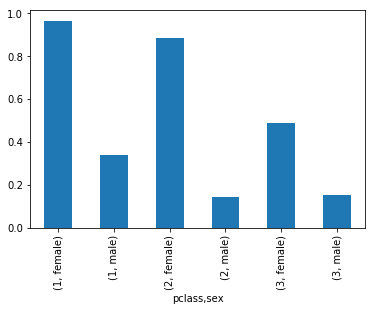

In [167]:
titanic_survivedSex = titanic.groupby(['pclass','sex']).apply(prop, 'survived', 1)
print(titanic_survivedSex)
titanic_survivedSex.T.plot(kind='bar')


*Discussion:* Women in first class had the highest survival chance. Almost 97% of them survived. This is followed by women in second and third class. Obviously the sex played a bigger roll than the passenger class. This is due to the fact that women and children where allowed to enter lifeboats first. Interestingly, man in third class had a better chance to survive than an in second class, while for women it was the other way around.

#### 6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

The two age categories are created the `qcut` function which uses empirical quantiles, in our case the median, to divide the data. As can be seen, the two groups are not of exactly same size. This is due to the fact that all people having the median age 28 are put in the same group (which seems reasonable). Afterwards the dataframe is grouped by the required attributes and the proportion is calculated similar to the proportions in questions 4 and 5. The group by operation results in a dataframe with a unique index as can be seen in the output of the call to `index.is_unique` and the task is solved.

In [168]:
titanic_ageCategories = titanic.copy()
titanic_ageCategories['age'] = pd.qcut(titanic_ageCategories.age, 2)
print(titanic_ageCategories.groupby(['age']).apply(len))

titanic_ageCategories = titanic_ageCategories.groupby(['age', 'pclass', 'sex']).apply(prop, 'survived', 1)
print(titanic_ageCategories)
print(titanic_ageCategories.index)
titanic_ageCategories.index.is_unique

age
(0.166, 28.0]    536
(28.0, 80.0]     510
dtype: int64
age            pclass  sex   
(0.166, 28.0]  1       female    0.951220
                       male      0.531250
               2       female    0.910714
                       male      0.216216
               3       female    0.513761
                       male      0.183036
(28.0, 80.0]   1       female    0.967391
                       male      0.302521
               2       female    0.872340
                       male      0.083333
               3       female    0.372093
                       male      0.144000
dtype: float64
MultiIndex(levels=[[(0.166, 28.0], (28.0, 80.0]], [1, 2, 3], ['female', 'male']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['age', 'pclass', 'sex'])


True

*Discussion:* As mentionned above, women and children where allowed to enter lifeboats first. Therefore, in tendency younger passengers had a better survival chance. As a consequence of the fact that women in general where admitted earlier, one can observe a bigger difference in the age categories of men. 